In [502]:
from functools import cmp_to_key

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
# set matplotlib backend to inline
%matplotlib inline

# import modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit

In [503]:
def read_nhl_data():
    _nhl_data = pd.read_csv('moneypack/all_teams.csv')
    _nhl_data = _nhl_data.dropna()

    columns_to_drop = [
        'name', 'gameId', 'playerTeam',
        'opposingTeam', 'home_or_away',
        'gameDate', 'position',
        'situation', 'iceTime',
        #'playoffGame'
    ]

    _nhl_data = _nhl_data.sort_values(by=['team', 'season'])
    _nhl_data = _nhl_data.drop(columns=columns_to_drop)
    _nhl_data = _nhl_data.groupby(['team', 'season'], as_index=False).mean()
    _nhl_data['playoff_qualified'] = _nhl_data['playoffGame'].apply(lambda val: 1 if val > 0 else 0)
    _nhl_data = _nhl_data.drop(columns=['playoffGame'])

    return _nhl_data


def read_nhl_data_2023():
    _nhl_data_2023 = pd.read_csv('moneypack/teams_2023.csv')
    columns_to_drop_from_2023 = ['name', 'position', 'situation', 'iceTime', 'team.1', 'games_played']

    _nhl_data_2023 = _nhl_data_2023.dropna()
    _nhl_data_2023 = _nhl_data_2023.drop(columns=columns_to_drop_from_2023)
    _nhl_data_2023 = _nhl_data_2023.sort_values(by=['team', 'season'])
    _nhl_data_2023 = _nhl_data_2023.groupby(['team', 'season']).mean()
    return _nhl_data_2023


def get_team_names(_team_data):
    return pd.DataFrame(_team_data['team']).drop_duplicates(subset=None, keep='first', inplace=False,
                                                            ignore_index=False)['team'].values

In [504]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2023)]
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2022)]

seasons_data_all = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_all = by_team_season_all['playoff_qualified'].values

In [505]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] == 2022)]

seasons_data_2022 = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_2022 = by_team_season_all['playoff_qualified'].values

In [506]:
seasons_data_2023 = read_nhl_data_2023()

In [507]:
from sklearn.feature_selection import f_classif

best_features = SelectKBest(score_func=f_classif, k=5).fit(seasons_data_all.values, seasons_target_all)
selected_features = seasons_data_all.columns[best_features.get_support()]
sorted_idxs = np.argsort(best_features.scores_)[::-1]
sorted_scores = best_features.scores_[sorted_idxs]
sorted_feature_names = np.array(seasons_data_all.columns)[sorted_idxs]
sorted_features_all = pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores})

# plt.figure(figsize=(20, 20))
# sns.barplot(x=sorted_scores, y=sorted_feature_names)
# plt.xlabel('Scores')
# plt.ylabel('Features')
# plt.title('Feature Importances using Univariate Feature Selection (Chi-square test)')
# plt.show()


In [508]:
sorted_features_all = sorted_features_all[sorted_features_all['score'] > 100]
sorted_features_all_names = sorted_features_all['feature'].values
seasons_data_2023 = seasons_data_2023[sorted_features_all_names]

scaler = StandardScaler()
seasons_data_all_features = scaler.fit_transform(seasons_data_all[sorted_features_all_names])
seasons_data_2022_features = scaler.fit_transform(seasons_data_2022[sorted_features_all_names])
seasons_data_2023_features = scaler.fit_transform(seasons_data_2023[sorted_features_all_names])


In [509]:
class MyKNearestNeighborsClassifier:
    pass

    def __init__(self, k):
        self.k = self.__validate_k(k)
        self.x_train = None
        self.y_train = None

    def fit(self, x_train, y_train):
        # np.unique(y) # classes
        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test):
        predicted_points = []
        for test_x_point in x_test:
            predicted_points.append(self.__predict_class(test_x_point))
        return np.array(predicted_points)

    def __predict_class(self, x_point):
        distances = []
        # calculate distances to all the training points
        for x_train_point in self.x_train:
            distances.append(self.__euclidean(x_train_point, x_point))

        nearest_indexes = np.argsort(distances)[:self.k]  # sort distances, take k nearest points' indices
        nearest_classes = self.y_train[nearest_indexes]  # take their classes
        # count number of occurrences of a class and return the index of max counter.
        return np.bincount(nearest_classes).argmax()

    def __euclidean(self, point1, point2):
        distance = np.sum(np.square(point1 - point2))
        return np.sqrt(distance)

    def __validate_k(self, k):
        if k <= 0:
            raise Exception("K cannot be less or equal to zero")

        k += 1  # Ties can be broken consistently by expanding K by 1
        return k

In [524]:
def plot_test_error(cv_result_details):
    test_error_data = pd.DataFrame(cv_result_details).head(10)
    test_error_data["test_error"].plot.hist(bins=10, edgecolor="black")
    plt.xlabel("Mean absolute error (k$)")
    _ = plt.title("Test error distribution")


def plot_learning_curve(estimator, x_data, y_data):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, x_data, y_data, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', shuffle=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Accuracy")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()


def run_cross_validation(classifier_instance, _data, _target, _cv, scoring='neg_root_mean_squared_error'):
    _cv_results = cross_validate(classifier_instance,
                                 _data, _target,
                                 cv=_cv, scoring=scoring,
                                 return_estimator=True)
    _cv_results["test_error"] = -_cv_results["test_score"]
    return _cv_results


def run_prediction(_cv_result, _class, _data, _target, _data_2022, _data_2023):
    plot_test_error(_cv_result)
    plot_learning_curve(_class, _data, _target)
    _y_pred_2022 = _class.predict(_data_2022)
    _y_pred_2023 = _class.predict(_data_2023)
    print(f'2022\n{_y_pred_2022}')
    print(f'2023\n{_y_pred_2023}')


In [525]:

cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
data = seasons_data_all_features
target = seasons_target_all

n_neighbors = 5
max_depth = 5

classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
classifier_knn_my = MyKNearestNeighborsClassifier(n_neighbors)
classifier_dec_tree = DecisionTreeClassifier(max_depth=max_depth)
voting_clf_hard = VotingClassifier(estimators=[('knn', classifier_knn), ('decision_tree', classifier_dec_tree)],
                                   voting='hard')
voting_clf_soft = VotingClassifier(estimators=[('knn', classifier_knn), ('decision_tree', classifier_dec_tree)],
                                   voting='soft')

cv_results_knn = run_cross_validation(classifier_knn, data, target, cv)
best_knn = cv_results_knn["estimator"][0]

cv_results_dec_tree = run_cross_validation(classifier_dec_tree, data, target, cv)
best_dec_tree = cv_results_dec_tree["estimator"][0]

cv_results_hard = run_cross_validation(voting_clf_hard, data, target, cv)
best_hard = cv_results_hard["estimator"][0]

cv_results_soft = run_cross_validation(voting_clf_soft, data, target, cv)
best_soft = cv_results_soft["estimator"][0]



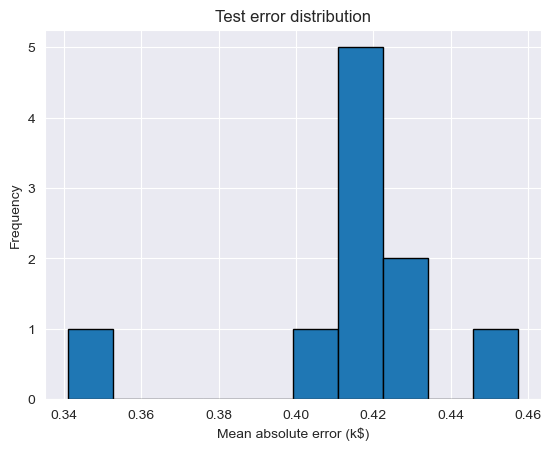

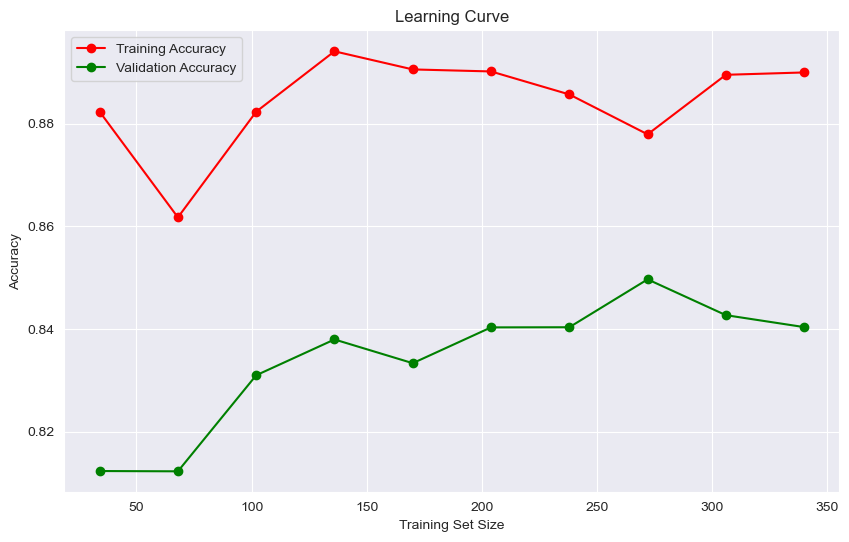

2022
[0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0]
2023
[0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0]


In [526]:
run_prediction(cv_results_knn, best_knn, data, target, seasons_data_2022_features, seasons_data_2023_features)

In [527]:
# run_prediction(cv_results_knn_my, best_knn_my, data, target, seasons_data_2022_features, seasons_data_2023_features)

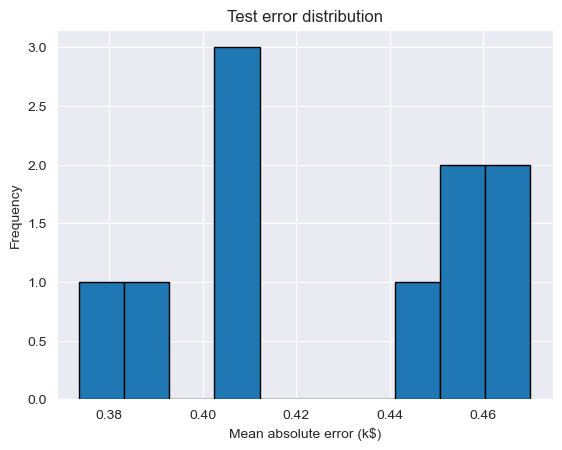

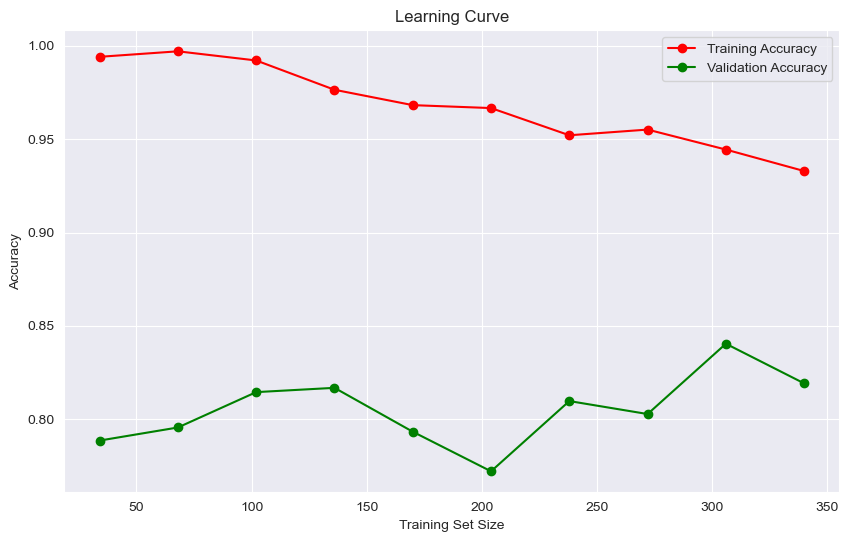

2022
[0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1]
2023
[0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0]


In [528]:
run_prediction(cv_results_dec_tree, best_dec_tree, data, target, seasons_data_2022_features, seasons_data_2023_features)

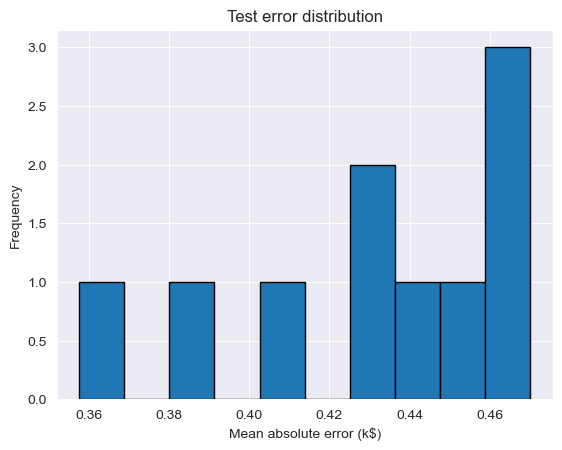

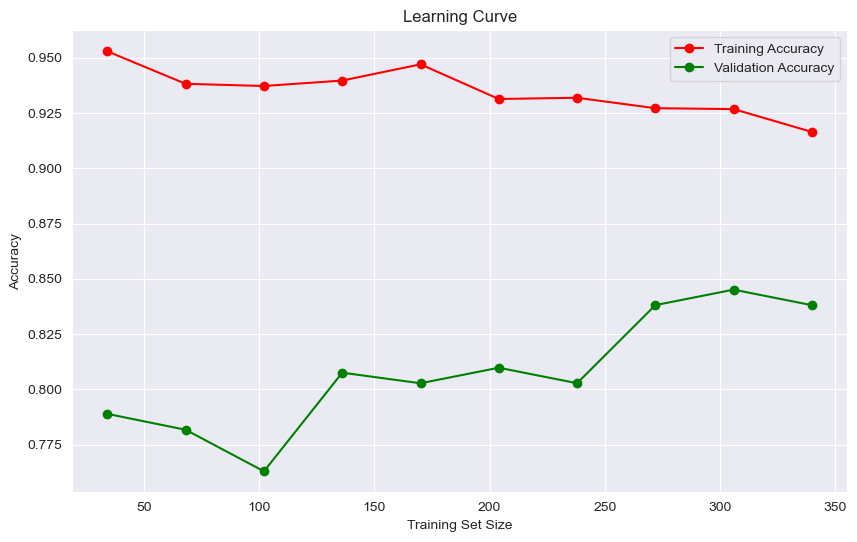

2022
[0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0]
2023
[0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0]


In [529]:
run_prediction(cv_results_hard, best_hard, data, target, seasons_data_2022_features, seasons_data_2023_features)

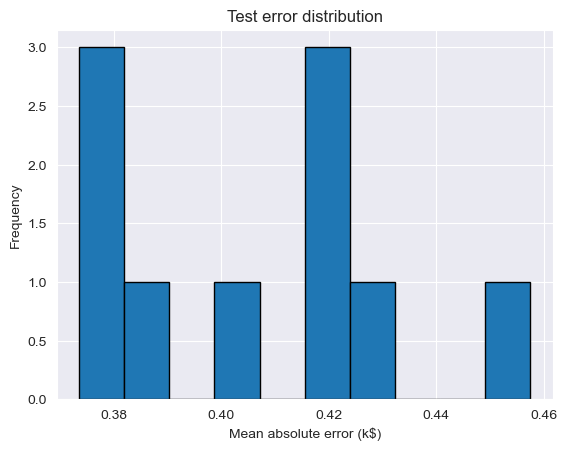

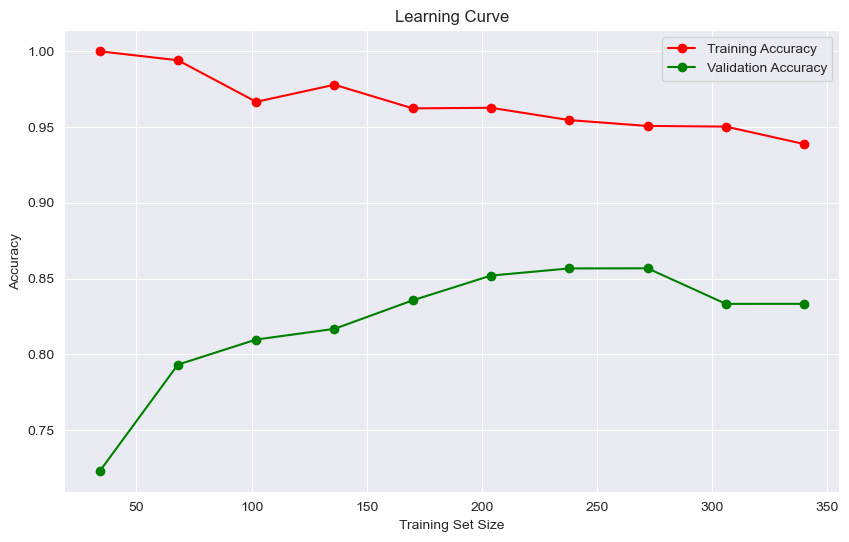

2022
[0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0]
2023
[0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0]


In [530]:
run_prediction(cv_results_soft, best_soft, data, target, seasons_data_2022_features, seasons_data_2023_features)